# Predicting Solar Flares with Flux Emergence Data

In this notebook, we will download and extract features from flux emergence data taken from Helioseismic and Magnetic Imager (HMI) instrument on NASA's Solar Dynamics Observatory (SDO) satellite, and train a machine learning model to predict the likelihood of an active region flaring.

TODO: CHANGE
The metadata from the HMI instrument is stored in a database called the Data Record Management System, or DRMS. This data can be accessed using the `drms` module. We will begin by importing the data.

In [143]:
import drms
import csv
import json
import requests
import math
import random
import scipy
import sunpy
import sunpy.instr.goes
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from datetime import datetime
from scipy.stats.kde import gaussian_kde

import movie

## Downloading Data

JSOC (Joint Science Operations Center) keeps an up-to-date catalog of all the active regions observed on the sun. This can be found here: `http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt`. The code block below takes a file `./data/all_harps_with_noaa_ars.txt` (which is a downloaded version of the aforementioned link) and extracts the harp_ids, as well as a dictionary of harp_ids corresponding to noaa_ids.

To download the newest version of the file, one could use a tool such as `wget`: `wget http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt`

In [144]:
def get_harp_ids_and_harp_noaa_dict():
    '''This method requires there to be a file ./data/all_harps_with_noaa_ars.txt with
    two columns: HARP IDs and NOAA IDs. This method returns a list of HARP IDs and a
    dictionary of HARP IDs corresponding to a list of NOAA IDs.
    '''
    harp_ids = []
    harp_noaa_dict = {}
    with open('./data/all_harps_with_noaa_ars.txt') as f:
        content = f.readlines()[1:] # Disregard the header line
        for line in content:
            harp_id = line.split()[0]
            noaa_ids = line.split()[1].split(',')
            harp_ids.append(int(harp_id))
            harp_noaa_dict[int(harp_id)] = noaa_ids
    return harp_ids, harp_noaa_dict

In [145]:
def query_data(harp_id):
    '''This method grabs data from the JSOC database. It currently gets two
    variables: time and unsigned flux. This method also makes sure the data received
    is high-quality and accurate.
    '''
    url_base = 'http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s'
    harp_id_string = '[' + str(harp_id) + ']'
    param_string = '[? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]'
    keys_string = '&op=rs_list&key=T_REC,USFLUX,TOTPOT,R_VALUE,AREA_ACR,CRVAL1,CRLN_OBS'
    url = url_base + harp_id_string + param_string + keys_string
    r = requests.get(url)
    assert r.status_code == 200
    data = json.loads(r.text)
    keys = pd.DataFrame()
    for keyword_data in data['keywords']:
        keyword = keyword_data['name']
        vals = keyword_data['values']
        keys[keyword] = vals
    return keys

In [146]:
def parse_time_string(t_str):
    year   = int(t_str[:4])
    month  = int(t_str[5:7])
    day    = int(t_str[8:10])
    hour   = int(t_str[11:13])
    minute = int(t_str[14:16])
    return datetime(year, month, day, hour, minute)

In [147]:
def convert_datetime_to_tai(t_obj):
    return str(t_obj.year) + '.' + str(t_obj.month) + '.' + str(t_obj.day) + '_' \
            + str(t_obj.hour) + ':' + str(t_obj.minute) + '_TAI'

In [148]:
def get_time_delta(start_time, end_time):
    '''Returns time difference between two given datetime objects in hours.
    '''
    return (end_time - start_time).total_seconds() / (60 * 60) # Convert to hours

In [149]:
def get_time_data(keys):
    start_time = parse_time_string(keys.T_REC[0])
    time_data = []
    for i in range(keys.T_REC.size):
        time = parse_time_string(keys.T_REC[i])
        time_data.append(get_time_delta(start_time, time))
    return time_data

In [150]:
def create_csv(keys, time_data, harp_id):
    '''Creates a csv file in ./data/[harp_id].csv with two columns: time and 
    unsigned_flux. This method will not write any data that occurs outside the
    range of +/- 70 degrees longitude from the meridian.
    '''
    data_dir = './data/'
    filename = data_dir + str(harp_id) + '.csv'
    with open(filename, 'w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['true_time', 'time', 'unsigned_flux', 'free energy',
                        'potential inversion line flux', 'area'])
        for i in range(len(keys.USFLUX)):
            if abs(float(keys.CRVAL1[i]) - float(keys.CRLN_OBS[i])) < 70.0:
                writer.writerow([keys.T_REC[i], time_data[i], keys.USFLUX[i], keys.TOTPOT[i],
                                keys.R_VALUE[i], keys.AREA_ACR[i]])

In [151]:
def create_all_csvs(harp_ids):
    '''This method creates a csv file with time and unsigned flux for
    all the HARP IDs in the inputted harp_ids.
    '''
    count = 0
    for harp_id in harp_ids:
        count += 1
        print(count, harp_id)
        if count % 100 == 0: print(count)
        keys = query_data(harp_id)
        time_data = get_time_data(keys)
        create_csv(keys, time_data, harp_id)

In [152]:
def read_data(harp_id):
    '''This method reads the data from ./data/[harp_id].csv, and returns a pandas
    DataFrame with two columns: time since the beginning of the active region data,
    and unsigned flux.
    '''
    filename = './data/' + str(harp_id) + '.csv'
    key_dict = {'TRUE_TIME': [], 'TIME': [], 'USFLUX': [], 'TOTPOT': [],
                'R_VALUE': [], 'AREA_ACR': []}
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        next(reader)  # Skip header
        for row in reader:
            if 'MISSING' in row: continue
            key_dict['TRUE_TIME'].append(parse_time_string(row[0]))
            key_dict['TIME'].append(float(row[1]))
            key_dict['USFLUX'].append(float(row[2]))
            key_dict['TOTPOT'].append(float(row[3]))
            key_dict['R_VALUE'].append(float(row[4]))
            key_dict['AREA_ACR'].append(float(row[5]))
    keys = pd.DataFrame(key_dict)
    return keys

In [153]:
def get_flare_data_from_database(t_start, t_end, min_event):
    '''This helper method simply grabs data from the GOES database. It returns
    the metadata associated with each flaring active region greater in event
    size than min_event and between time t_start and t_end.
    '''
    time_range = sunpy.time.TimeRange(t_start, t_end)
    results = sunpy.instr.goes.get_goes_event_list(time_range, min_event)
    return results

In [154]:
def get_flare_data(harp_ids, min_event):
    '''This method accesses the GOES database to get the flare data for each
    HARP ID in the inputted harp_ids.
    '''
    first_keys = query_data(harp_ids[0])
    t_start = first_keys.T_REC[0]
    last_keys = query_data(harp_ids[-1])
    t_end = last_keys.T_REC[len(last_keys.T_REC) - 1]
    print('Time range:', t_start, 'to', t_end)

    return get_flare_data_from_database(t_start, t_end, min_event)

In [155]:
def write_noaa_data_to_csv(flare_data):
    with open('./data/noaa_data.csv', 'w') as csv_file:
        field_names = flare_data[0].keys()
        writer = csv.DictWriter(csv_file, fieldnames=field_names)
        writer.writeheader()
        for flare in flare_data:
            writer.writerow(flare)

In [156]:
def get_noaa_data_from_csv():
    noaa_flare_set = []
    with open('./data/noaa_data.csv', 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            noaa_flare_set.append(dict(row))
    return noaa_flare_set

In [157]:
# Set recreate_data to True if you want to redownload all the data (takes 30+ minutes)
recreate_data = False

harp_ids, harp_noaa_dict = get_harp_ids_and_harp_noaa_dict()

if recreate_data:
    create_all_csvs(harp_ids)
    #flare_data = get_flare_data(harp_ids, 'X1.0')
    #write_noaa_data_to_csv(flare_data)
else:
    flare_data = get_noaa_data_from_csv()

print('Number of active regions:', len(harp_ids))
print('Number of flares:', len(flare_data))

x_flare_data = get_flare_data(harp_ids, 'X1.0')
print('Number of X class flares:', len(x_flare_data))

Number of active regions: 1335
Number of flares: 8029
Time range: 2010.05.01_00:12:00_TAI to 2019.05.19_07:12:00_TAI
Number of X class flares: 45


## Data Processing

Our raw data, obtained in the "Downloading Data" section, consists of three data structures: a list of the HARP IDs `harp_ids`, a dictionary relating the HARP IDs to the NOAA IDs `harp_noaa_dict`, and the flare data downloaded from GOES `flare_data`.

In the next blocks of code, we will process the data in various ways to extract information and relate the raw data described above.

In [158]:
def get_flared_noaa_id_set(flare_data):
    '''This method returns a list of all the NOAA IDs that have
    flared, based on the data passed in from flare_data.
    '''
    noaa_flare_set = set()
    for flare in flare_data:
        noaa_flare_set.add(int(flare['noaa_active_region']))
    return noaa_flare_set

In [159]:
def has_flared(harp_id, harp_noaa_dict, noaa_flare_set):
    '''Returns a boolean corresponding to whether the given active
    region corresponding to the harp_id flared or not.
    '''
    for noaa_id in harp_noaa_dict[harp_id]:
        if int(noaa_id) in noaa_flare_set:
            return True
    return False

In [160]:
def get_harp_id_to_flaring_times_dict(harp_noaa_dict, flare_data):
    '''This method returns a dictionary where the keys are HARP IDs and
    the values are a list of peak times where the given active region flared.
    Times are given in units of hours after the first time in the harp_id data.
    If the active region corresponding to the HARP IDs did not flare, then
    the list will be empty.
    '''
    noaa_id_flare_time_dict = {}
    for flare in flare_data:
        time = flare['peak_time']
        noaa_id = int(flare['noaa_active_region'])
        if noaa_id in noaa_id_flare_time_dict.keys():
            noaa_id_flare_time_dict[noaa_id] += [time]
        else:
            noaa_id_flare_time_dict[noaa_id] = [time]
    flare_time_dict = {}
    for harp_id in harp_noaa_dict.keys():
        keys = read_data(harp_id)
        flare_time_dict[int(harp_id)] = []
        if len(keys.TRUE_TIME) == 0: continue
        datetime_start = keys.TRUE_TIME[0]
        hour_start = keys.TIME[0]
        for noaa_id in harp_noaa_dict[harp_id]:
            if int(noaa_id) not in noaa_id_flare_time_dict.keys(): continue
            time_array = []
            for time in noaa_id_flare_time_dict[int(noaa_id)]:
                time_array.append(hour_start + get_time_delta(datetime_start, parse_time_string(str(time))))
            flare_time_dict[int(harp_id)] += time_array
    return flare_time_dict

In [161]:
def find_unlabeled_flares_above_minimum(flare_data, min_class='M5.0'):
    '''While looking at the NOAA data, I noticed that the NOAA ID of some flares
    were labeled as 0. This method finds and returns flare_data entries that have
    an NOAA ID of 0, and have a GOES class above min_class. This is used to see
    if any of the unlabeled flares interfere with the learning algorithm.
    '''
    unlabeled_flare_list = []
    for flare in flare_data:
        if flare['noaa_active_region'] == '0':
            goes_class = flare['goes_class']
            classes = ['c', 'm', 'x']
            if (
                classes.index(goes_class[0].lower()) > classes.index(min_class[0].lower()) or
                (classes.index(goes_class[0].lower()) == classes.index(min_class[0].lower()) and
                float(goes_class[1:]) > float(min_class[1:]))
            ):
                unlabeled_flare_list.append(flare)
    return unlabeled_flare_list

In [162]:
def count_flared_num(harp_ids, harp_noaa_dict, noaa_flare_set):
    '''This method returns the number of active regions in the inputted
    harp_ids that have flared.
    '''
    number_flared = 0
    for harp_id in harp_ids:
        if has_flared(harp_id, harp_noaa_dict, noaa_flare_set): number_flared += 1
    return number_flared

In [163]:
def get_segmented_data(harp_ids, flare_time_dict, n=None, return_harp_ids=False):
    '''This method returns two arrays: x and y. The x array includes time series
    data, while y represents whether the corresponding active region in x flared.
    
    The x and y arrays are built according to the following rule:
        - If a flare occurs within 24 hours after sample time t, it is considered
        to belong to the positive case (i.e. the corresponding y entry will be True).
        - If no flare occurs within 24 hours, it is considered to belong to the
        negative case.
    
    The x array is an array of arrays, where each array represents a 24-hour set of
    data corresponding to an active region. Each of these 24-hour arrays are arrays of
    tuples representing the (time, flux) at each recorded interval within the 24 hours.
    
    The n parameter refers to how many negative data points. If n is set to None (default),
    then the number of negative data points = the number of positive data points.
    '''
    num_no_flare = 0
    num_flares = 0
    for harp_id in harp_ids:
        data = flare_time_dict[harp_id]
        if not data: num_no_flare += 1
        num_flares += len(data)
    if n != None:
        num_samples_per_datapoint = math.ceil(n / num_no_flare)
    else:
        n = num_flares
        num_samples_per_datapoint = math.ceil(num_flares / num_no_flare)
    x = []
    y = []
    harp_list = []
    num_negative = 0
    for harp_id in harp_ids:
        keys = read_data(harp_id)
        flare_data = flare_time_dict[harp_id]
        if flare_data:
            for flare_time in flare_data:
                # Throw out flare data with less than 24 hours of preceding data
                if flare_time - keys.TIME[0] > 24 and flare_time < keys.TIME.iloc[-1]:
                    data = []
                    for i, time in enumerate(keys.TIME):
                        if time <= flare_time and time >= flare_time - 24:
                            data.append((time, keys.USFLUX[i]))
                    if not data or data[-1][0] - data[0][0] < 23:
                        # Insufficient data
                        continue
                    x.append(data)
                    harp_list.append(harp_id)
                    y.append(True) # True => flare is present
        else:
            if len(keys.TIME) <= 0 or keys.TIME.iloc[-1] - keys.TIME[0] < 24 or \
                (n != None and num_negative >= n): continue
            for _ in range(num_samples_per_datapoint):
                end = keys.TIME[0]
                while end - keys.TIME[0] < 24:
                    end = keys.TIME[random.randrange(len(keys.TIME))]
                data = []
                for i, time in enumerate(keys.TIME):
                    if time <= end and time >= end - 24:
                        data.append((time, keys.USFLUX[i]))
                if not data or data[-1][0] - data[0][0] < 23:
                    # Insufficient data
                    continue
                x.append(data)
                harp_list.append(harp_id)
                y.append(False) # False => flare is not present
                num_negative += 1
    if return_harp_ids:
        return x, y, harp_list
    else:
        return x, y

In [164]:
def get_decreasing_x_class_flares(x_flares_seg_x, x_flares_harp_list):
    '''This method returns a dictionary of all the X class flaring regions that decrease
    in flux over their lifespan. The dictionary keys are the HARP IDs of the X class flares
    and the values are tuples of the (start_time, end_time) of the active region data.
    '''
    decreasing_dict = {}
    for i, x_flare_data in enumerate(x_flares_seg_x):
        if x_flare_data[0][1] - x_flare_data[-1][1] > 0:
            harp_id = x_flares_harp_list[i]
            data = read_data(harp_id)
            start_row = data.loc[data['TIME'] == x_flare_data[0][0]]
            start_time = convert_datetime_to_tai(start_row.iloc[0]['TRUE_TIME'])
            end_row = data.loc[data['TIME'] == x_flare_data[-1][0]]
            end_time = convert_datetime_to_tai(end_row.iloc[0]['TRUE_TIME'])
            if harp_id in decreasing_dict:
                decreasing_dict[harp_id] += [(start_time, end_time)]
            else:
                decreasing_dict[harp_id] = [(start_time, end_time)]
        #print(x_flare_data)
        #print(read_data(harp_id))
    return decreasing_dict

In [165]:
def get_non_flaring_regions(seg_x, seg_y, harp_list, flaring=False, n=10):
    time_dict = {}
    count = 0
    for i, region_data in enumerate(seg_x):
        if count >= n: break
        if flaring == seg_y[i]:
            harp_id = harp_list[i]
            data = read_data(harp_id)
            start_row = data.loc[data['TIME'] == region_data[0][0]]
            start_time = convert_datetime_to_tai(start_row.iloc[0]['TRUE_TIME'])
            end_row = data.loc[data['TIME'] == region_data[-1][0]]
            end_time = convert_datetime_to_tai(end_row.iloc[0]['TRUE_TIME'])
            if harp_id in time_dict:
                time_dict[harp_id] += [(start_time, end_time)]
            else:
                time_dict[harp_id] = [(start_time, end_time)]
            count += 1
    return time_dict

In [166]:
noaa_flare_set = get_flared_noaa_id_set(flare_data)

flare_time_dict = get_harp_id_to_flaring_times_dict(harp_noaa_dict, flare_data)
x_flare_time_dict = get_harp_id_to_flaring_times_dict(harp_noaa_dict, x_flare_data)

#min_class = 'M1.0'
#unlabeled_flare_list = find_unlabeled_flares_above_minimum(flare_data, min_class=min_class)
#print('Number of unlabeled flares ≥', min_class + ':', len(unlabeled_flare_list))

number_flared = count_flared_num(harp_ids, harp_noaa_dict, noaa_flare_set)
print(number_flared, 'active regions flared out of', len(harp_ids))

649 active regions flared out of 1335


In [167]:
seg_x, seg_y, harp_list = get_segmented_data(harp_ids, flare_time_dict, n=25, return_harp_ids=True)
positive_count, negative_count = 0, 0
for has_flare in seg_y:
    if has_flare: positive_count += 1
    else: negative_count += 1
print('# Positive:', positive_count, '--- # Negative:', negative_count)

# Positive: 4552 --- # Negative: 25


In [168]:
print(len(x_flare_time_dict))
x_flares_seg_x, x_flares_seg_y, x_flares_harp_list = get_segmented_data(harp_ids, x_flare_time_dict,
                                                                        n=0, return_harp_ids=True)
print(len(x_flares_seg_x))

1335
23


10


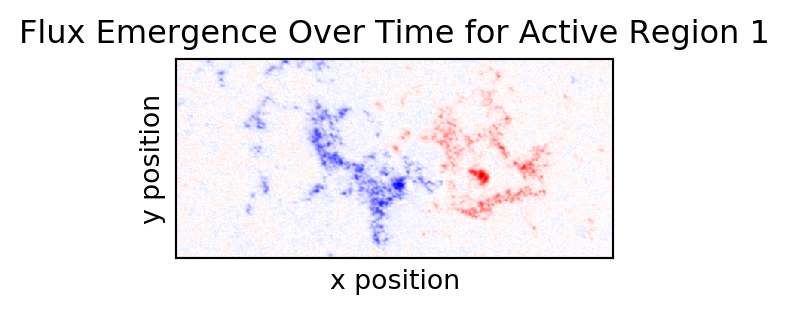

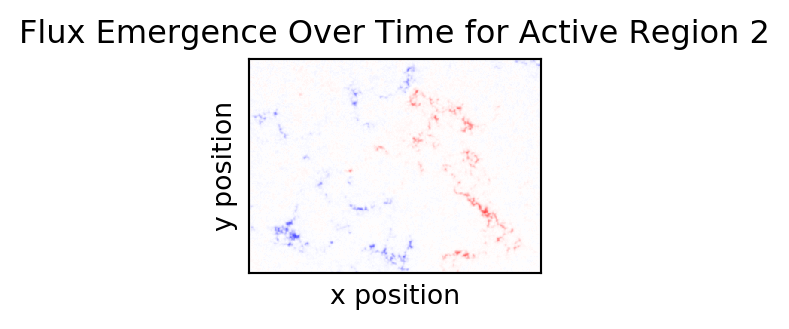

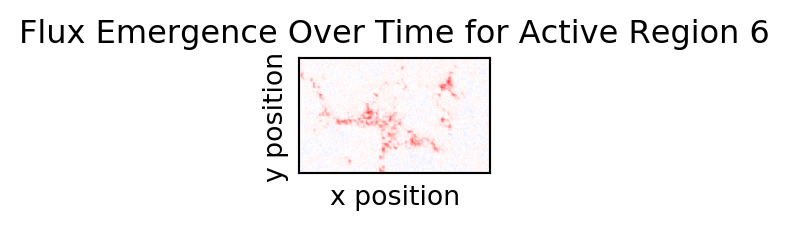

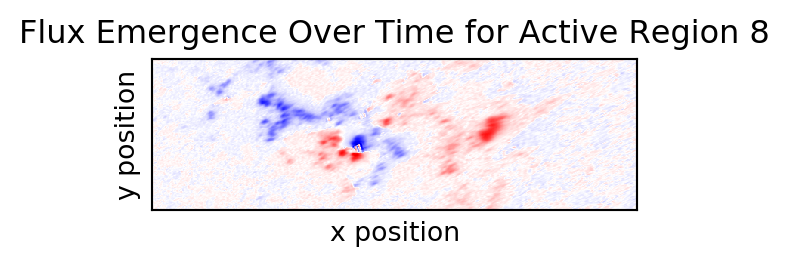

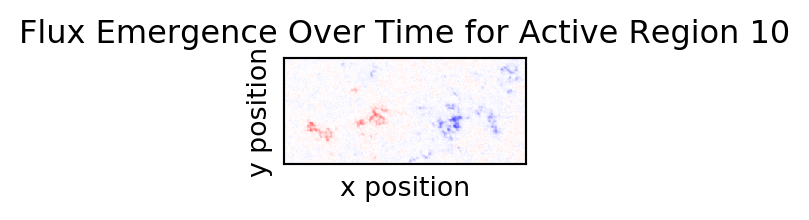

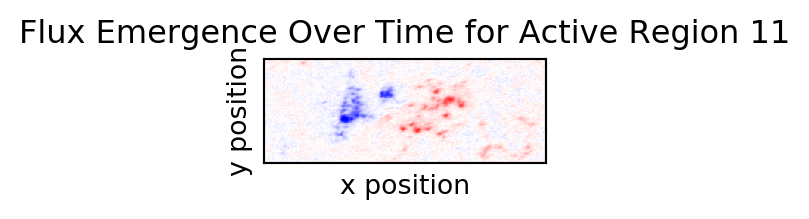

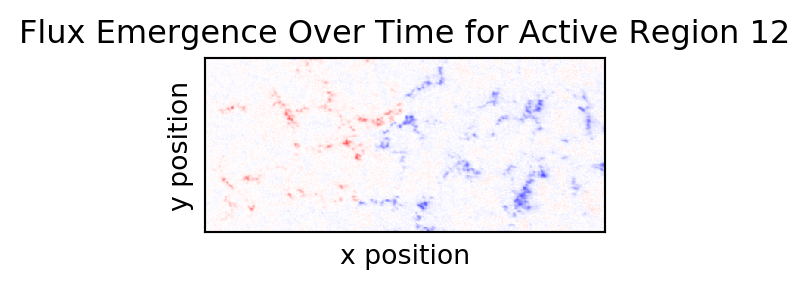

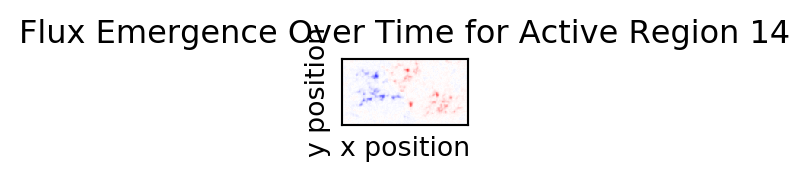

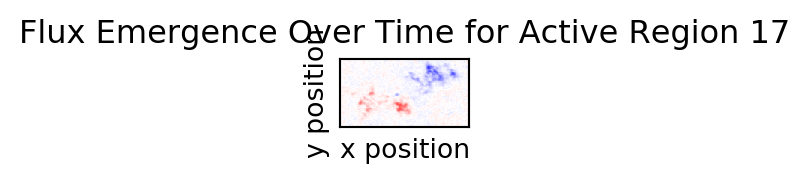

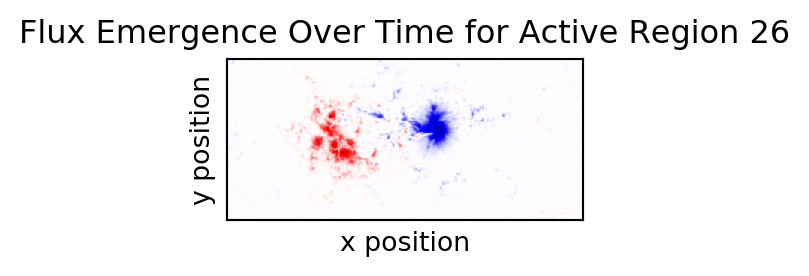

In [105]:
#decreasing_x_class_flares = get_decreasing_x_class_flares(x_flares_seg_x, x_flares_harp_list)
#print(len(decreasing_x_class_flares))

non_flaring_times = get_non_flaring_regions(seg_x, seg_y, harp_list)
print(len(non_flaring_times))

time_data = non_flaring_times

for key in time_data:
    data = time_data[key]
    for data_tuple in data:
        movie.save_animation(key, data_tuple[0], data_tuple[1], time_interval='1h')

## Visualizing Data

We want to be able to graph the data in order to visually understand the differences between the flux vs. time graphs of flaring and non-flaring active regions.

In [176]:
def plot_graph(x, y, x_label, y_label, title, clr=None, scatter=False,
               line=None, vertical_lines=None, formula=None, label=None):
    '''This method uses matplotlib to create a graph of x vs. y.
    '''
    # Style elements
    text_style = dict(fontsize=12, fontdict={'family': 'monospace'})

    # Add data
    if scatter:
        plt.scatter(x, y, color=clr, label=label)
    else:
        plot = plt.plot(x, y, '.', color=clr, linestyle=line, label=label)
    
    if vertical_lines:
        for x_val in vertical_lines:
            plt.axvline(x=x_val, color=clr)
    plt.axhline(y=0, color='black', linewidth=1)
    
    if formula:
        x_vals = np.array(x)
        y_vals = formula(x_vals)
        plt.plot(x, y_vals, color=clr)

    # label the axes and the plot
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    ax.set_xlabel(x_label, **text_style)
    ax.set_ylabel(y_label, **text_style)
    ax.set_title(title, **text_style)
    if label: plt.legend()

In [170]:
def plot_flux_time_graphs(harp_ids, color=None, flare_time_dict=None):
    '''This method will graph all the flux vs. time data from the inputted
    harp_ids on the same plot. This is useful for seeing how different flux
    emergences look simultaneously. If flare_time_dict is specified,
    this method will plot vertical lines at the times where the given harp_id
    flares.
    '''
    for harp_id in harp_ids:
        keys = read_data(harp_id)
        us_flux_data = list(map(lambda x : float(x) / 1e22, keys.USFLUX))
        time_data = list(keys.TIME)
        start_time = time_data[0]
        if flare_time_dict and flare_time_dict[harp_id]:
            vertical_lines = flare_time_dict[harp_id]
        else:
            vertical_lines = None
        plot_graph(time_data, us_flux_data, 'Hours Since Active Region Detected',
                  'Unsigned Flux (Maxwells x 10^22)', 'Unsigned Flux vs. Time for Active Regions',
                  clr=color, vertical_lines=vertical_lines)
    plt.show()

In [171]:
def plot_flux_time_derivative_graphs(harp_ids, color=None, flare_time_dict=None):
    '''This method will graph all the slope of flux vs. time data from the inputted
    harp_ids on the same plot. This is useful for seeing how different flux
    emergences look simultaneously.
    '''
    for harp_id in harp_ids:
        keys = read_data(harp_id)
        us_flux_data = list(map(lambda x : float(x) / 1e22, keys.USFLUX))
        us_flux_derivative_data = []
        time_data = keys.TIME
        interval = 100 # Interval of data to take
        new_time_data = []
        for i, flux in enumerate(us_flux_data):
            if i % interval != 0: continue
            if i >= len(us_flux_data) - interval: break
            flux_change = us_flux_data[i + interval] - flux
            time_change = time_data[i + interval] - time_data[i]
            new_time_data.append(time_data[i])
            us_flux_derivative_data.append(flux_change / time_change)
        if flare_time_dict and flare_time_dict[harp_id]:
            vertical_lines = flare_time_dict[harp_id]
        else:
            vertical_lines = None
        plot_graph(new_time_data, us_flux_derivative_data, 
                   'Hours Since Active Region Detected', 'Flux derivative (Maxwells x 10^22)',
                   'Unsigned Flux Derivative vs. Time for Active Regions', clr=color, line='-',
                   vertical_lines=vertical_lines)
    plt.show()

In [172]:
def plot_random_graphs(harp_ids, harp_noaa_dict, noaa_flare_set, flare=True,
                       n=10, color=None, derivative=False, flare_time_dict=None):
    '''This method plots n random unsigned flux vs. time graphs. If flare=True,
    it will plot graphs of active regions that have flared. Else, it will plot
    graphs of active regions that have not flared.
    '''
    def plot(harp_id):
        if derivative:
            plot_flux_time_derivative_graphs([harp_id], color, flare_time_dict=flare_time_dict)
        else:
            plot_flux_time_graphs([harp_id], color, flare_time_dict=flare_time_dict)

    c = drms.Client()
    count = 0
    ids = harp_ids.copy()
    random.shuffle(ids)
    for harp_id in ids:
        if flare:
            if has_flared(harp_id, harp_noaa_dict, noaa_flare_set):
                count += 1
                plot(harp_id)
                if count >= n: break
        else:
            if not has_flared(harp_id, harp_noaa_dict, noaa_flare_set):
                count += 1
                plot(harp_id)
                if count >= n: break

In [180]:
def plot_segmented_graphs(seg_x, seg_y, flare=True, n=5, color=None):
    '''This method plots n random graphs that correspond to flaring active 
    regions if flare is True, and non-flaring active regions if flare is False.
    '''
    for _ in range(n):
        i = random.randrange(len(seg_y))
        while seg_y[i] != flare:
            i = random.randrange(len(seg_y))
        data = seg_x[i]
        x, y = [], []
        for t, f in data:
            x.append(t)
            y.append(f / 1e22)
        plot_graph(x, y, 'Hours Since Active Region Detected',
                    'Unsigned Flux (Maxwells x 10^22)',
                    'Unsigned Flux vs. Time for Active Region', clr=color)
        plt.show()

In [174]:
def overlay_plots(seg_x, n=float('inf'), linear_fit=False, quadratic_fit=False,
                 polynomial_fit=False, exponential_fit=False):
    count = 0
    for i, data in enumerate(seg_x):
        count += 1
        if count > n: break
        x, y = [], []
        start_time = data[0][0]
        start_flux = data[0][1]
        for t, f in data:
            x.append(t - start_time)
            y.append((f - start_flux) / 1e21)

        formula = None

        def f_linear(x, a, b):
            return a * x + b
        if linear_fit:
            popt, _ = scipy.optimize.curve_fit(f_linear, x, y)
            formula = lambda x : popt[0] * x + popt[1]

        def f_quad(x, a, b, c):
            return a * x ** 2 + b * x + c
        if quadratic_fit:
            popt, _ = scipy.optimize.curve_fit(f_quad, x, y)
            formula = lambda x : popt[0] * x ** 2 + popt[1] * x + popt[2]

        def f_poly(x, a, b, c, d):
            return a * x ** 3 + b * x ** 2 + c * x + d
        if polynomial_fit:
            popt, _ = scipy.optimize.curve_fit(f_poly, x, y)
            formula = lambda x : popt[0] * x ** 3 + popt[1] * x ** 2 + popt[2] * x + popt[3]

        def f_exp(x, a, b):
            return a * b ** x
        if exponential_fit:
            popt, _ = scipy.optimize.curve_fit(f_exp, x, y)
            formula = lambda x : popt[0] * popt[1] ** x

        colors = matplotlib.colors.TABLEAU_COLORS
        plot_graph(x, y, 'Hours Since Start of 24hr Time Frame',
                        'Unsigned Flux (Maxwells x 10^22)',
                        'Unsigned Flux vs. Time for Active Region',
                        formula=formula, clr=colors[list(colors.keys())[i % len(colors)]])
    plt.show()

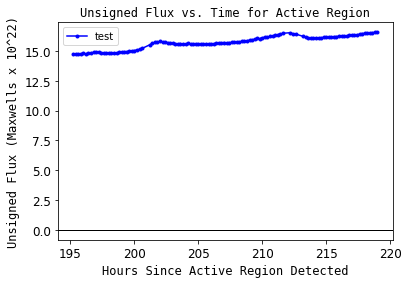

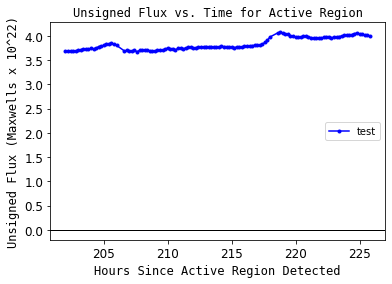

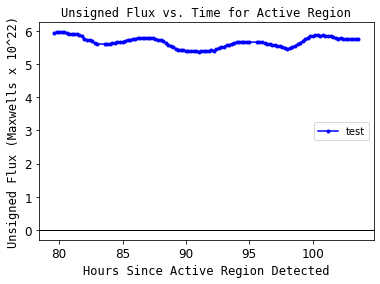

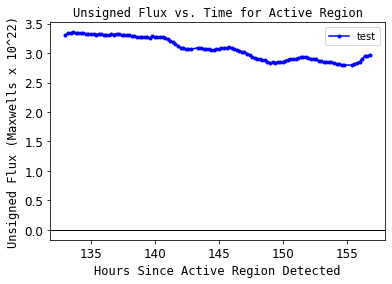

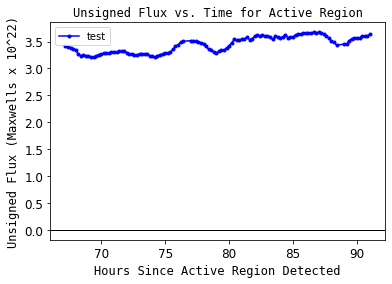

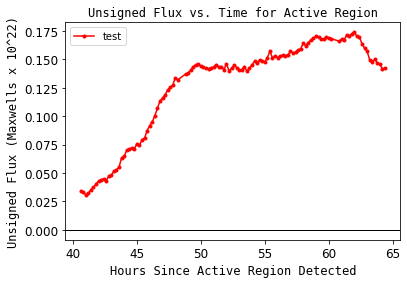

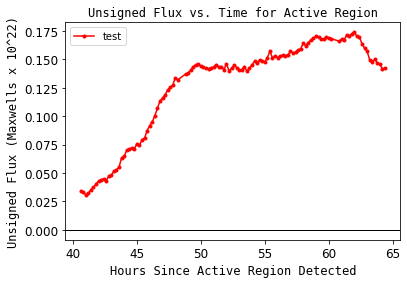

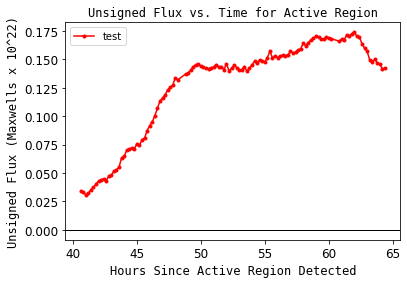

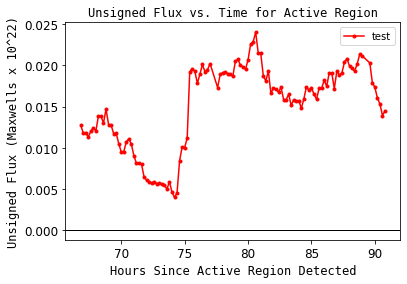

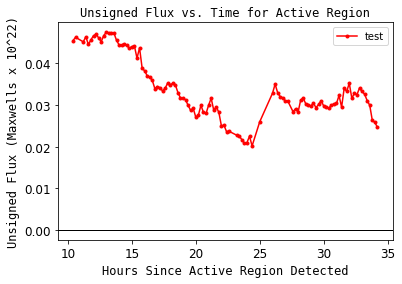

In [179]:
# plot_flux_time_graphs(harp_ids[:1])
# plot_flux_time_derivative_graphs(harp_ids[:5])

# num_graphs = 2
# plot_random_graphs(harp_ids, harp_noaa_dict, noaa_flare_set, n=num_graphs,
#                    color='b', derivative=False,
#                    flare_time_dict=flare_time_dict)
# plot_random_graphs(harp_ids, harp_noaa_dict, noaa_flare_set, False, n=num_graphs,
#                    color='r', derivative=True,
#                    flare_time_dict=flare_time_dict)\
num_graphs = 5
plot_segmented_graphs(seg_x, seg_y, flare=True, n=num_graphs, color='blue')
plot_segmented_graphs(seg_x, seg_y, flare=False, n=num_graphs, color='red')

# overlay_plots(x_flares_seg_x, n=50, linear_fit=False, quadratic_fit=False,
#              polynomial_fit=False, exponential_fit=False)
# no_flares_seg_x = []
# for i, is_flared in enumerate(seg_y):
#     if not is_flared: no_flares_seg_x.append(seg_x[i])
# overlay_plots(no_flares_seg_x, n=5, linear_fit=False, quadratic_fit=False,
#              polynomial_fit=False, exponential_fit=False)

## Learning

This next section includes all the feature extraction and learning segments of the code.

In [113]:
def mean_flux(flux_data):
    return np.mean(flux_data)

In [114]:
def std_flux(flux_data):
    return np.std(flux_data)

In [115]:
def max_flux(flux_data):
    return max(flux_data)

In [116]:
def flux_range(flux_data):
    return max(flux_data) - min(flux_data)

In [117]:
def time_range(time_data):
    return np.ptp(time_data)

In [118]:
def slope_to_max(flux_data, time_data):
    max_flux_value = (max_flux(flux_data))
    i = flux_data.index(max_flux_value)
    if time_data[i] == 0: # TODO: Investigate why/when this happens
        return 0
    return max_flux_value / time_data[i]

In [119]:
def derivative_sum(flux_data, time_data, interval=1):
    total_derivative = 0
    for i, flux in enumerate(flux_data):
        if i % interval != 0: continue
        if i >= len(flux_data) - interval: break
        flux_change = flux_data[i + interval] - flux
        time_change = time_data[i + interval] - time_data[i]
        total_derivative += abs(flux_change / time_change)
    return total_derivative

In [120]:
def extract_features(harp_id):
    '''Given a harp_id, this method returns an array of features corresponding to the
    active region corresponding to the harp_id.

    Current features are:
        Mean unsigned flux
        Standard deviation of unsigned flux
        Maximum flux
        Time range (i.e. how long the active region existed)
        Slope to the maximum flux (max flux / time)
        The sum of the absolute values of the slopes for the data in the graph

    NOTE: in order for this method to work, there must exist a csv file containing time and
    unsigned flux in ./data/[harp_id].csv. This can be obtained using the create_csv method.
    '''
    # Get data from CSV
    filename = './data/' + str(harp_id) + '.csv'
    time_data = []
    flux_data = []
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        next(reader)  # Skip header
        for row in reader:
            time_data.append(float(row[0]))
            flux_data.append(float(row[1])/1e21)

    # Extract features
    features = []
    features.append(mean_flux(flux_data))
    features.append(std_flux(flux_data))
    features.append(max_flux(flux_data))
    features.append(flux_range(flux_data))
    features.append(time_range(time_data))
    features.append(slope_to_max(flux_data, time_data))
    features.append(derivative_sum(flux_data, time_data))
    
    return features

In [ ]:
print(extract_features(1))

In [121]:
def create_binary_learning_dataset(harp_ids):
    '''Given a harp_id, this method returns two arrays: x and y. The x array is an array of
    feature arrays corresponding to each harp_id. y is an array of booleans indicating whether
    each active region flared or not.
    The output of this method can easily be applied to a machine learning algorithm.
    '''
    x, y = [], []
    for harp_id in harp_ids:
        x.append(extract_features(harp_id))
        y.append(has_flared(harp_id, harp_noaa_dict, noaa_flare_set))
    return x, y

In [ ]:
x, y = create_binary_learning_dataset(harp_ids)

# New ML stuff below

In [122]:
def regression_helper(function, time_data, flux_data):
    popt, _ = scipy.optimize.curve_fit(function, time_data, flux_data)
    residuals = flux_data - function(time_data, *popt)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((flux_data - np.mean(flux_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return popt, r_squared

In [123]:
def linear_features(time_data, flux_data, feature_names=False):
    def f_linear(x, a, b):
        return a * x + b
    popt, r_squared = regression_helper(f_linear, time_data, flux_data)
    if feature_names:
        return np.array([*popt, r_squared]), ['slope', 'intercept', 'r^2_linear']
    return np.array([*popt, r_squared])

In [124]:
def exponential_features(time_data, flux_data, feature_names=False):
    def f_exponential(x, a, b):
        return a * b ** x
    popt, r_squared = regression_helper(f_exponential, time_data, flux_data)
    if feature_names:
        return np.array([popt[1], r_squared]), ['exp_val', 'r^2_exp']
    return np.array([popt[1], r_squared])

In [125]:
def quadratic_features(time_data, flux_data, feature_names=False):
    def f_quad(x, a, b, c):
        return a * x ** 2 + b * x + c
    popt, r_squared = regression_helper(f_quad, time_data, flux_data)
    if feature_names:
        return np.array([*popt, r_squared]), ['quad_1', 'quad_2', 'quad_3', 'r^2_quad']
    return np.array([*popt, r_squared])

In [126]:
def cubic_features(time_data, flux_data, feature_names=False):
    def f_cubic(x, a, b, c, d):
        return a * x ** 3 + b * x ** 2 + c * x + d
    popt, r_squared = regression_helper(f_cubic, time_data, flux_data)
    if feature_names:
        return np.array([*popt, r_squared]), ['cube_1', 'cube_2', 'cube_3', 'cube_4', 'r^2_cube']
    return np.array([*popt, r_squared])

In [127]:
def discrete_features(time_data, flux_data, feature_names=False):
    features = []
    features.append(np.mean(flux_data))
    if feature_names:
        return features, ['mean']

In [128]:
def extract_time_series_features(time_data, flux_data, features):
    feature_list = np.array([])
    feature_names = []
    for feature in features:
        data, names = feature(time_data, flux_data, feature_names=True)
        feature_list = np.append(feature_list, data)
        feature_names += names
    return feature_list, feature_names

In [129]:
def create_learning_dataset(seg_x, seg_y, features):
    '''Creates learning dataset with time series data.
    '''
    x, y = [], []
    for i, data in enumerate(seg_x):
        if len(data) < 3: continue
        time_data, flux_data = [], []
        for t, f in data:
            time_data.append(t)
            flux_data.append(f / 1e22)
        #print(seg_y[i])
        time_data = np.array(time_data)
        flux_data = np.array(flux_data)
        data, names = extract_time_series_features(time_data, flux_data, features)
        x.append(data)
        y.append(seg_y[i])
    return x, y, names

In [ ]:
features = [cubic_features]
raw_x, y, feature_names = create_learning_dataset(seg_x, seg_y, features)
print('Features used:', feature_names)

In [130]:
def scale_x_data(x):
    '''Method to scale each feature in the inputted x data to a range of 0 to 1.
    Returns the scaled data.
    '''
    scaler = MinMaxScaler()
    return scaler.fit_transform(x)

In [ ]:
x = scale_x_data(raw_x)

In [131]:
def graph_features(x, y, feature_names, max_num_graphs=float('inf')):
    '''Given the feature data as x, this function will graph features versus each other.
    Different outputs in y will be displayed in different colors. The function will graph
    every combination of features, and print them.
    '''
    single_feature_vectors = [[] for _ in range(len(x[0]))]
    colors = []
    color_map = {True: 'r', False: 'b'}
    for i, data_pt in enumerate(x):
        colors.append(color_map[y[i]])
        for j in range(len(data_pt)):
            single_feature_vectors[j].append(data_pt[j])
    count = 0
    for i in range(len(x[0])):
        for j in range(i + 1, len(x[0])):
            count += 1
            plot_graph(single_feature_vectors[i], single_feature_vectors[j],
                       feature_names[i], feature_names[j],
                       feature_names[i].title() + ' vs. ' + feature_names[j].title(),
                       clr=colors, scatter=True)
            plt.show()
            if count >= max_num_graphs: break
        if count >= max_num_graphs: break

In [ ]:
graph_features(x, y, feature_names)

In [132]:
def make_histogram(x, y, index, title=None, num_bins=10, pdf=False):
    feature_data = [[], []]
    for i, data_pt in enumerate(x):
        if y[i]:
            feature_data[0].append(data_pt[index])
        else:
            feature_data[1].append(data_pt[index])
    colors = ['blue', 'red']
    plt.hist(feature_data, bins=num_bins, color=colors, edgecolor='black', alpha=0.5)
    if pdf:
        for i, data in enumerate(feature_data):
            kde = gaussian_kde(data)
            dist_space = np.linspace(min(data), max(data), 100)
            plt.plot(dist_space, kde(dist_space), color=colors[i])
            #sorted_data = sorted(data)
            #plt.plot(sorted_data, scipy.stats.norm.pdf(sorted_data))
    ax = plt.gca()
    ax.set_title(title)
    plt.show()

In [ ]:
for i in range(len(feature_names)):
    make_histogram(x, y, i, title=feature_names[i].title(), pdf=True)

## Different Classification Algorithms and Their Pros and Cons

1. Suppport Vector Machines (SVMs)
  * SVMs work by constructing hyper-planes in higher dimensional space. This can be used for classification by maximizing the distance between the hyper-plane and the training data of any class.
  * This is a good choice because it is a versatile classification algorithm.
2. Stochastic Gradient Descent
  * Creates a linear classifier to minimize loss.
  * Less versatile than SVMs (this should not be an issue for the binary classification, however).
  * Scikitlearn has the following built-in loss functions: hinge loss, modified Huber, and logistic.
3. Multi-layer Perceptron
  * Can learn non-linear models.
  * Doesn't necessarily find global optimum: different initial weights can alter validation accuracy.
  * Needs tweaking of hyperparameters such as the number of hidden neurons, layers, and iterations to work well.
4. AdaBoost (Boosting algorithm)
  * Principle is to combine many weak learners to create one strong model.
  * Each weak learner concentrates on the examples that are missed by the previous learners.
5. Random Forest
  * Each tree is built from a random sample of the total data (with replacement).
  * This tends to reduce the overall bias.

In [133]:
def fit_algorithm(clf, x, y, n=1):
    '''This method will fit the given classifier clf to the input x, y data
    and will return the training and test accuracy of the model.
    This method will randomize the train/test split n number of times and will
    return the average train/test accuracy.'''
    avg_train, avg_test = 0, 0
    for _ in range(n):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
        clf.fit(x_train, y_train)
        avg_train += clf.score(x_train, y_train)
        avg_test += clf.score(x_test, y_test)
    return avg_train / n, avg_test / n

In [134]:
def print_info(clf, x, y, algorithm_name, best_accuracy=0, best_algorithm=None):
    '''This method streamlines the code required to fit the given clf to the 
    model, as well as print out important statistics. This method returns the new
    best algorithm and best accuracy, based on the test accuracy.
    '''
    print(algorithm_name + ':')
    train_accuracy, test_accuracy = fit_algorithm(clf, x, y, 50)
    print('> Train accuracy:', train_accuracy)
    print('> Test accuracy:', test_accuracy)
    result_vals_dict = {'TP': 0, 'FP': 0, 'TN': 0, 'FN':0}
    for i, data_pt in enumerate(x):
        prediction = clf.predict([data_pt])
        if prediction == y[i]:
            if prediction == 1:
                result_vals_dict['TP'] += 1
            else:
                result_vals_dict['TN'] += 1
        else:
            if prediction == 1:
                result_vals_dict['FP'] += 1
            else:
                result_vals_dict['FN'] += 1
    precision = result_vals_dict['TP'] / (result_vals_dict['TP'] + result_vals_dict['FP'])
    recall = result_vals_dict['TP'] / (result_vals_dict['TP'] + result_vals_dict['FN'])
    tss_score = recall - result_vals_dict['FP'] / (result_vals_dict['FP'] + result_vals_dict['TN'])
    print('> Precision:', precision)
    print('> Recall:', recall)
    print('> TSS Score:', tss_score)
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_algorithm = algorithm_name
    return best_algorithm, best_accuracy

In [285]:
for i, a in enumerate(raw_x):
    print(a, y[i])

[0.53632154] False
[0.07739949] False
[0.07701128] False
[0.98566178] False
[0.03545147] False
[0.30621729] False
[0.81987156] False
[0.05894938] False
[0.06192382] False
[0.60850745] False
[0.05675519] False
[0.14411934] False
[0.24125182] False
[0.10901777] False
[0.03230063] False
[0.31753545] False
[0.18064135] False
[0.51108476] False
[0.75839484] False
[0.51675821] False
[0.02627541] False
[0.10925563] False
[0.44511523] False
[0.14099635] False
[3.28373137] False
[2.45760351] True
[3.15118186] True
[1.6013195] True
[1.62600535] True
[4.18286533] True
[5.39535851] True
[5.40303332] True
[6.62498882] True
[8.6162094] True
[6.52081519] True
[4.34665668] True
[3.49263804] True
[8.39692918] True
[13.38742628] True
[14.77747257] True
[17.48947638] True
[19.44796198] True
[4.00446133] True
[10.19213548] True
[2.46963876] True
[4.01308389] True
[4.13999941] True
[5.34799186] True


In [136]:
def run_learning_algorithms(x, y):
    '''This method runs different machine learning (ML) algorithms and prints 
    statements indicated the accuracy, finally printing the best overall algorithm 
    in terms of test accuracy.
    
    Current ML algorithms:
        Support Vector Machine
        Stochastic Gradient Descent
        Multi-layer Perceptron
        AdaBoost
        Random Forest
    '''
    best_accuracy = 0
    best_algorithm = None

    #algorithm_name = 'Support Vector Machine'
    #clf = SVC(gamma='scale')
    #best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    #print('>', clf.support_vectors_, '\n')

    algorithm_name = 'Stochastic Gradient Descent'
    clf = SGDClassifier(loss='hinge', penalty='l2')
    best_algorithm, best_accuracy = print_info(clf, raw_x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.coef_, '\n')

    #algorithm_name = 'Multi-layer Perceptron'
    #clf = MLPClassifier(max_iter=500)
    #best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    #print('>', clf.loss_, '\n')

    algorithm_name = 'AdaBoost'
    clf = AdaBoostClassifier(n_estimators=25, random_state=0)
    best_algorithm, best_accuracy = print_info(clf, raw_x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.feature_importances_, '\n')
    print(clf.get_params())

    algorithm_name = 'Random Forest'
    clf = RandomForestClassifier(n_estimators=25, max_depth=2, random_state=0)
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.feature_importances_, '\n')

    print('The best algorithm is', best_algorithm, 'with a test accuracy of', best_accuracy)

In [ ]:
run_learning_algorithms(x, y)

- add discrete features?
- look at m and x esp. x
- ~~Plot x class flares and fits~~
- ~~skill scores -- look at paper~~
- regression problem for continuous data?
- upper or lower limits for flaring behavior
- multiclass classification